# Introducción al experiment tracking con MLflow – JAIIO 2025

### Configuración inicial

Importamos todas las librerías necesarias, configuramos MLflow para usar un servidor local y definimos el experimento donde se registrarán las ejecuciones.


In [1]:
import matplotlib.pyplot as plt
import mlflow
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from datetime import datetime
from mlflow.tracking import MlflowClient
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm import tqdm

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("mnist-classifier")

2025/08/05 17:22:01 INFO mlflow.tracking.fluent: Experiment with name 'mnist-classifier' does not exist. Creating a new experiment.


<Experiment: artifact_location='/root/mlflow/artifacts/1', creation_time=1754414521963, experiment_id='1', last_update_time=1754414521963, lifecycle_stage='active', name='mnist-classifier', tags={}>

### Preparación del dataset MNIST

Descargamos el dataset MNIST, lo normalizamos, lo separamos en conjuntos de entrenamiento, validación y test, y creamos los dataloaders correspondientes.

In [2]:
def get_data_loaders():

    print("Creating data loaders")

    BATCH_SIZE = 1024

    dataloader_kwargs = {
        'batch_size': BATCH_SIZE,
        'num_workers': 1,
        'persistent_workers': True,
        'pin_memory': True,
        'shuffle': True
    }

    data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    train_dataset_full = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)

    train_size = int(0.85 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size

    seed = 42
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(seed)
    )

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

    dataloaders = {}
    dataloaders["train"] = DataLoader(train_dataset,**dataloader_kwargs)
    dataloaders["val"] = DataLoader(val_dataset, **dataloader_kwargs)
    dataloaders["test"] = DataLoader(test_dataset, **dataloader_kwargs)

    print("Data loaders created successfully")

    return dataloaders

### Definición del modelo

Definimos una red neuronal convolucional estilo LeNet-5 con dos capas `Conv2d`, dos capas `Dropout` y dos `Linear`. Utiliza `log_softmax` como capa de salida.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Función de entrenamiento del modelo

Función que entrena el modelo durante varias épocas, calcula métricas por fase (train y val), y las registra en MLflow. También guarda el modelo entrenado y lo registra en el Model Registry.


In [33]:
def train(model, device, dataloaders, num_epochs):

    print("\nStarting training...")

    learning_rate = 1.0
    optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

    mlflow.log_param("optimizer", "Adadelta")
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("scheduler_step_size", 1)
    mlflow.log_param("scheduler_gamma", 0.7)
    mlflow.log_param("epochs", num_epochs)
    mlflow.log_param("batch_size", dataloaders["train"].batch_size)

    for epoch in range(num_epochs):
        print()
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct = 0

            # Wrap dataloader with tqdm for progress bar
            loop = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Phase", leave=False)

            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = F.nll_loss(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_correct += torch.sum(preds == labels)

                # Update tqdm description dynamically
                loop.set_postfix({
                    "Loss": f"{loss.item():.4f}",
                    "Batch Acc": f"{(preds == labels).float().mean().item():.4f}"
                })

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)

            mlflow.log_metric(f"{phase}_loss", epoch_loss, step=epoch)
            mlflow.log_metric(f"{phase}_acc", epoch_acc, step=epoch)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
    os.makedirs("model", exist_ok=True)
    torch.save(model.state_dict(), "model/mnist_cnn.pt")
    mlflow.pytorch.log_model(model, "model", registered_model_name="MNISTClassifier")
    print("\nTraining complete.")
            

### Matriz de confusión

Calculamos la matriz de confusión con el conjunto de test, la visualizamos y la guardamos como artefacto en MLflow.


In [34]:
def log_confusion_matrix(model, dataloader, device):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')

    os.makedirs("artifacts", exist_ok=True)
    cm_path = f"artifacts/confusion_matrix.png"
    plt.savefig(cm_path)
    plt.close()

    mlflow.log_artifact(cm_path, artifact_path="plots")


### Visualización de errores

Identificamos y graficamos ejemplos de imágenes mal clasificadas por el modelo. Guardamos la imagen resultante como artefacto en MLflow.


In [35]:
def log_misclassified_images(model, dataloader, device, max_images=25):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            mismatches = preds != labels

            for i in range(inputs.size(0)):
                if mismatches[i]:
                    errors.append((inputs[i].cpu(), preds[i].item(), labels[i].item()))
                if len(errors) >= max_images:
                    break
            if len(errors) >= max_images:
                break

    if errors:
        fig, axes = plt.subplots(5, 5, figsize=(10, 10))
        for ax, (img, pred, true) in zip(axes.flat, errors):
            ax.imshow(img.squeeze(), cmap="gray")
            ax.set_title(f"P: {pred} / T: {true}")
            ax.axis('off')
        plt.tight_layout()

        img_path = "artifacts/misclassified.png"
        plt.savefig(img_path)
        plt.close()

        mlflow.log_artifact(img_path, artifact_path="plots")


### Evaluación del modelo entrenado

Evaluamos el modelo en el conjunto de test, registramos las métricas en MLflow y generamos los artefactos visuales correspondientes.


In [36]:
def test(model, device, test_loader):
    print("\nStarting testing...")

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += F.nll_loss(outputs, labels, reduction='sum').item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)

    test_loss /= len(test_loader.dataset)
    test_acc = correct.double() / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * test_acc))
    
    mlflow.log_metric(f"test_loss", test_loss)
    mlflow.log_metric(f"test_acc", test_acc)
    
    log_confusion_matrix(model, test_loader, device)

    log_misclassified_images(model, test_loader, device)

### Ejecución completa del flujo de entrenamiento

Creamos una ejecución de MLflow (`run`), seteamos parámetros, tags y seed, preparamos los datos, entrenamos el modelo y lo evaluamos.


In [37]:
def training_workflow():

    with mlflow.start_run(run_name=f"mnist_run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"):

        MANUAL_SEED = 42
        torch.manual_seed(MANUAL_SEED)
        mlflow.log_param("manual_seed", MANUAL_SEED)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f'Device: {device}\n')

        mlflow.set_tag("model_type", "LeNet-5")
        mlflow.set_tag("data_scientist", "Facundo Galan")
        mlflow.set_tag("dataset", "MNIST")
        mlflow.set_tag("framework", "PyTorch")
        mlflow.set_tag("device", device)

        dataloaders = get_data_loaders()

        model = Net().to(device)

        train(model, device, dataloaders, num_epochs=5)
        
        test(model, device, dataloaders["test"])

### Ejecutar entrenamiento

Llamamos a la función que realiza todo el flujo de entrenamiento y evaluación.


In [38]:
training_workflow()

Device: cuda

Creating data loaders
Data loaders created successfully

Starting training...


Epoch 1/5
------------------------------


train Loss: 0.7993 Acc: 0.7495


val Loss: 0.1545 Acc: 0.9541


Epoch 2/5
------------------------------


train Loss: 0.1696 Acc: 0.9504


val Loss: 0.1016 Acc: 0.9694


Epoch 3/5
------------------------------


train Loss: 0.1174 Acc: 0.9649


val Loss: 0.0788 Acc: 0.9772


Epoch 4/5
------------------------------


train Loss: 0.0921 Acc: 0.9726


val Loss: 0.0657 Acc: 0.9804


Epoch 5/5
------------------------------


train Loss: 0.0820 Acc: 0.9757


2025/08/05 17:27:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/05 17:27:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


val Loss: 0.0601 Acc: 0.9824


2025/08/05 17:27:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.1+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.7.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/05 17:27:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'MNISTClassifier' already exists. Creating a new version of this model...
2025/08/05 17:27:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MNISTClassifier, version 5



Training complete.

Starting testing...


Created version '5' of model 'MNISTClassifier'.



Test set: Average loss: 0.0468, Accuracy: 9842/10000 (98.42%)

🏃 View run mnist_run_20250805_172701 at: http://127.0.0.1:5000/#/experiments/1/runs/c7a19d47826e4dc1b83c6348366e4dce
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### Publicación del modelo en MLflow Model Registry

Obtenemos la última versión del modelo registrado y la promovemos a la etapa Staging. También asignamos tags personalizados como comentarios y versión semántica.


In [10]:
client = MlflowClient()
model_name = "MNISTClassifier"

latest_versions = client.get_latest_versions(model_name, stages=["None"])
model_version = latest_versions[0].version

client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage="Staging",  # También puede ser "Production", "Archived"
)

client.set_model_version_tag(model_name, model_version, "comment", "First stable version of MNIST classification model.")
client.set_model_version_tag(model_name, model_version, "custom_version", "v1.0.0")


/tmp/ipykernel_3916/3624062240.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(model_name, stages=["None"])
/tmp/ipykernel_3916/3624062240.py:7: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


### Inferencia con modelo desde el Model Registry

Realizamos una predicción utilizando el modelo previamente registrado en el Model Registry, actualmente en la etapa Staging.


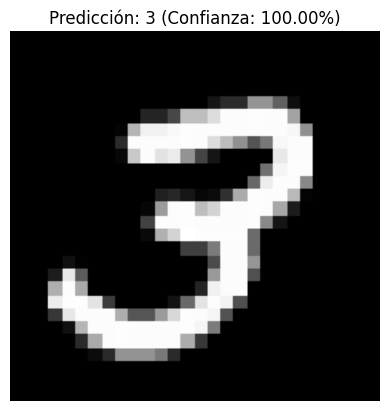

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_path = "./images/three_example.png"
image = Image.open(image_path)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
input_tensor = transform(image).unsqueeze(0).to(device)

model_uri = "models:/MNISTClassifier/Staging"
model = mlflow.pytorch.load_model(model_uri).to(device)
model.eval()

with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.exp(output)
    pred_label = torch.argmax(probabilities, dim=1).item()
    confidence = torch.max(probabilities).item()

plt.imshow(image, cmap="gray")
plt.title(f"Predicción: {pred_label} (Confianza: {confidence:.2%})")
plt.axis("off")
plt.show()